# Gradient & Sigmoid Windowing

I've been exploring a bunch of different ways to window the DICOM images and I thought I'd share a few ideas and results.

Huge thanks to [David Tang](https://www.kaggle.com/dcstang/see-like-a-radiologist-with-systematic-windowing), [Marco](https://www.kaggle.com/marcovasquez/basic-eda-data-visualization), [Nanashi](https://www.kaggle.com/jesucristo/rsna-introduction-eda-models), [Richard McKinley](https://www.kaggle.com/omission/eda-view-dicom-images-with-correct-windowing) and [Ryan Epp](https://www.kaggle.com/reppic/gradient-sigmoid-windowing) for their amazing Kernels that I totally borrowed code and ideas from. Though the original notebook and idea of gradient and sigmoid windowing was applied for [RSNA Intracranial Hemorrhage Detection Challenge](https://www.kaggle.com/c/rsna-intracranial-hemorrhage-detection), in my view these techniques can put serious impact on the competition's LB. 

**Contents**<br>
&#10687; [1. No Windowing](#1)<br>
&#10687; [2. Lung Windowing](#2)<br>
&#10687; [3. Metadata Windowing](#3)<br>
&#10687; [4. One Window, Three Channels](#4)<br>
&#10687; [5. Gradient Windowing](#5)<br>
&#10687; [6. Mapping Multiple Windows in Multiple Channels](#6)<br>
&#10687; [7. Exclusive Windowing](#7)<br>
&#10687; [8. Gradient Ensemble Windowing](#8)<br>
&#10687; [9. Sigmoid Windowing](#9)<br>
&#10687; [10. Sigmoid Ensemble Windowing](#10)<br>
&#10687; [11. Sigmoid Gradient Ensemble Windowing](#11)<br>
&#10687; [12. Acknowledgements](#12)<br>

### Importing Packages and Setting Data Path

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import pydicom as dcm
import os
import glob
import random

TRAIN_IMG_PATH = "../input/rsna-str-pulmonary-embolism-detection/train/"
TEST_IMG_PATH = "../input/rsna-str-pulmonary-embolism-detection/test/"

train_df = pd.read_csv("../input/rsna-str-pulmonary-embolism-detection/train.csv")
test_df = pd.read_csv("../input/rsna-str-pulmonary-embolism-detection/test.csv")

# Uncomment this lines to get a list of paths of all training and testing files
# train_file_paths = glob.glob("../input/rsna-str-pulmonary-embolism-detection/train/*/*/*.dcm")
# test_file_paths = glob.glob("../input/rsna-str-pulmonary-embolism-detection/test/*/*/*.dcm")

Let's select an experiment or examination which has both positive and negative sample. Here an experiment is handpicked so that it has half positive samples and half negative samples.

In [2]:
exam_UID = '6897fa9de148'
exam = train_df[train_df["StudyInstanceUID"] == exam_UID]
positive_exam_paths = []
negative_exam_paths = []

for index, row in exam.iterrows():
    if row["pe_present_on_image"]:
        positive_exam_paths.append('../input/rsna-str-pulmonary-embolism-detection/train/' + 
                                  row["StudyInstanceUID"] + '/' +
                                  row['SeriesInstanceUID'] + '/' + 
                                  row['SOPInstanceUID'] + '.dcm')
    else:
        negative_exam_paths.append('../input/rsna-str-pulmonary-embolism-detection/train/' + 
                                  row["StudyInstanceUID"] + '/' +
                                  row['SeriesInstanceUID'] + '/' + 
                                  row['SOPInstanceUID'] + '.dcm')

print(f'Statistics for examination UID: {exam_UID}')
print('pe_present_on_image -> (Positive): ', len(positive_exam_paths))
print('pe_present_on_image -> (Negative): ', len(negative_exam_paths))

Statistics for examination UID: 6897fa9de148
pe_present_on_image -> (Positive):  42
pe_present_on_image -> (Negative):  82


In [3]:
def load_random_images(no_of_samples = 10):    
    img_paths = random.sample(positive_exam_paths, no_of_samples//2)
    img_paths += random.sample(negative_exam_paths, no_of_samples//2)
    return [dcm.read_file(img_path) for img_path in img_paths]


def view_images(images, cmap = plt.cm.bone ):
    width = len(images)//2
    height = 2
    fig, axs = plt.subplots(height, width, figsize=(20,8))
    
    for im in range(0, height * width):
        image = images[im]
        i = im // width
        j = im % width
        axs[i,j].imshow(image, cmap=cmap) 
        axs[i,j].axis('off')
        if i==0:
            title = 'pe_present=1'
        else:
            title = 'pe_present=0'
        axs[i,j].set_title(title)
    plt.show()
    

def get_first_of_dicom_field_as_int(x):
    #get x[0] as in int is x is a 'pydicom.multival.MultiValue', otherwise get int(x)
    if type(x) == dcm.multival.MultiValue: return int(x[0])
    else: return int(x)

    
def get_windowing(data):
    dicom_fields = [data[('0028','1050')].value, #window center
                    data[('0028','1051')].value, #window width
                    data[('0028','1052')].value, #intercept
                    data[('0028','1053')].value] #slope
    return [get_first_of_dicom_field_as_int(x) for x in dicom_fields]

print('Loaded utility functions successfully')

Loaded utility functions successfully


Let's load a some images. We'll randomly pick five from positive example from each class and five negative examples. We will see the same examples through out the whole notebook so it is easier to distinguish them.

DICOM Pixel Data Shape:  [(512, 512), (512, 512), (512, 512), (512, 512), (512, 512), (512, 512), (512, 512), (512, 512), (512, 512), (512, 512)]


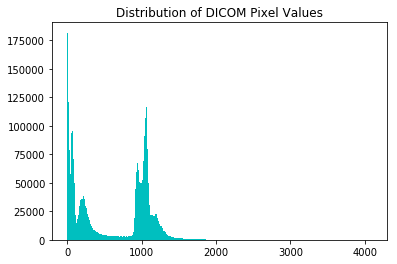

In [4]:
imgs = load_random_images()
print('DICOM Pixel Data Shape: ', [img_pixels.pixel_array.shape[:]  for img_pixels in imgs])

plt.title('Distribution of DICOM Pixel Values')
ax = plt.hist(np.array([img.pixel_array for img in imgs]).flatten(), bins=300, color='c')

We can see the DICOM data is 2-dimensional and has a range of values much wider than the typical png or jpg image. Let's remind ourselves what the scans look like if we include the full range of values... 

<a id="1"></a>
<font color="black" size=+2.5><b>1. No Windowing </b></font>

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to Colors">Go to TOC</a>

### Default color model <font color="blue">plt.cm.bone</font>

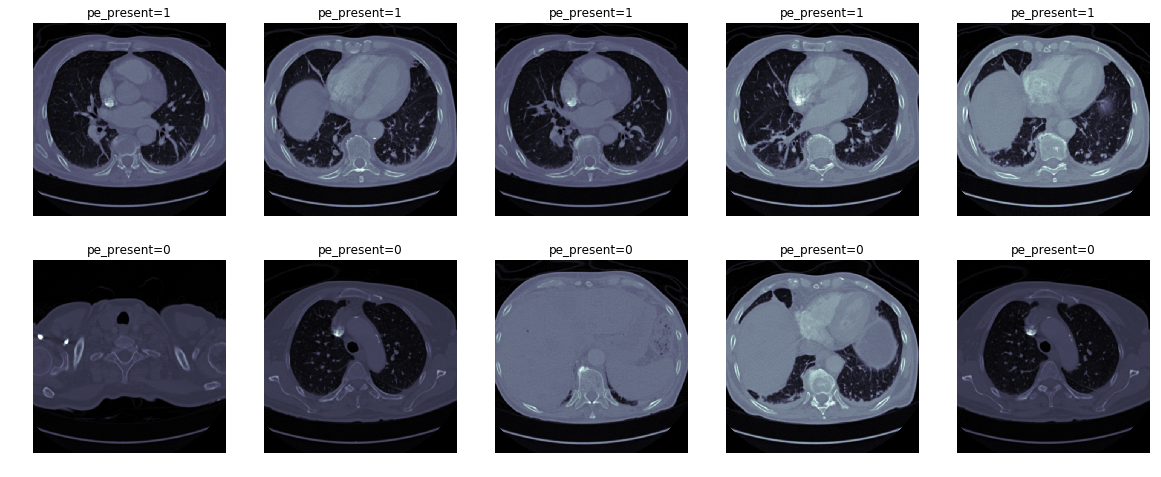

In [5]:
view_images([img.pixel_array for img in imgs] )

### Default color model <font color="blue">plt.cm.gray</font>

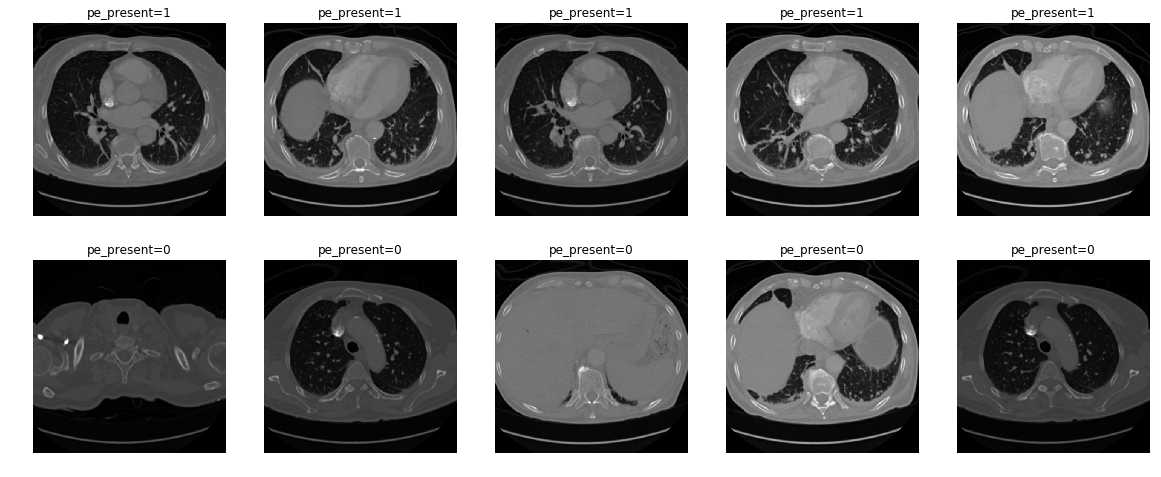

In [6]:
view_images([img.pixel_array for img in imgs], cmap = 'gray')

These don't look very useful for pulmonary embolism.

[David Tang's Kernel](https://www.kaggle.com/dcstang/see-like-a-radiologist-with-systematic-windowing) and [Richard McKinley's Kernel](https://www.kaggle.com/omission/eda-view-dicom-images-with-correct-windowing) both do a great job at explaining windowing and how it's used by radiologists. (Make sure to check them out!)

The way I've been thinking about it, is **how do we transform our 2D scan data into 3D image data in a way that makes it easy for our model to detect PE?**

<a id="2"></a>
<font color="black" size=+2.5><b>2. Lung Windowing </b></font>

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to Colors">Go to TOC</a>

Let's check out the range of values that corresponds with lung tissues. I take values from [radiopedia.org](https://radiopaedia.org/articles/windowing-ct) We'll clip everything outside that range so that there's more contrast in the lung-tissue range.

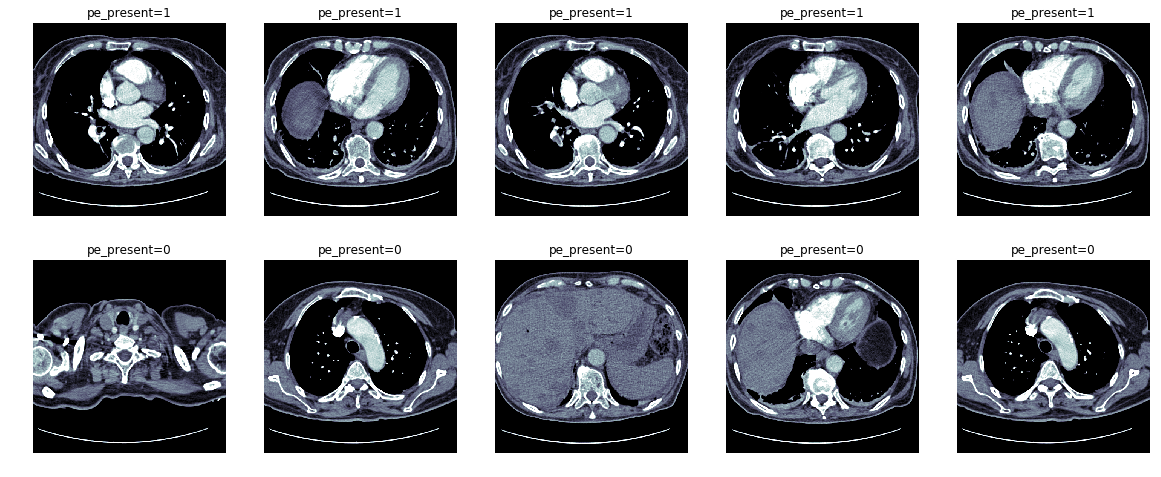

In [7]:
def lung_window(img):
    window_min = -125
    window_max = 225
    _, _, intercept, slope = get_windowing(img)
    img = img.pixel_array
    img = img * slope + intercept
    img[img < window_min] = window_min
    img[img > window_max] = window_max
    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    return img

view_images([lung_window(img) for img in imgs])

<a id="3"></a>
<font color="black" size=+2.5><b>3. Metadata Windowing </b></font>

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to Colors">Go to TOC</a>

The DICOM images come with metadata specifying a window center and width. Which was used when that CT-Scan was taken. We could also use these values instead of the fixed range from above. We can simply extract the metadata from the DICOM files. However for the first time, we will use that default windowing and later on we will use different windowing parameters based on our need.

Metadata Window Ranges:
Window Level: 40, Window Width:400, Range:[-160 240]
Window Level: 40, Window Width:400, Range:[-160 240]
Window Level: 40, Window Width:400, Range:[-160 240]
Window Level: 40, Window Width:400, Range:[-160 240]
Window Level: 40, Window Width:400, Range:[-160 240]
Window Level: 40, Window Width:400, Range:[-160 240]
Window Level: 40, Window Width:400, Range:[-160 240]
Window Level: 40, Window Width:400, Range:[-160 240]
Window Level: 40, Window Width:400, Range:[-160 240]
Window Level: 40, Window Width:400, Range:[-160 240]


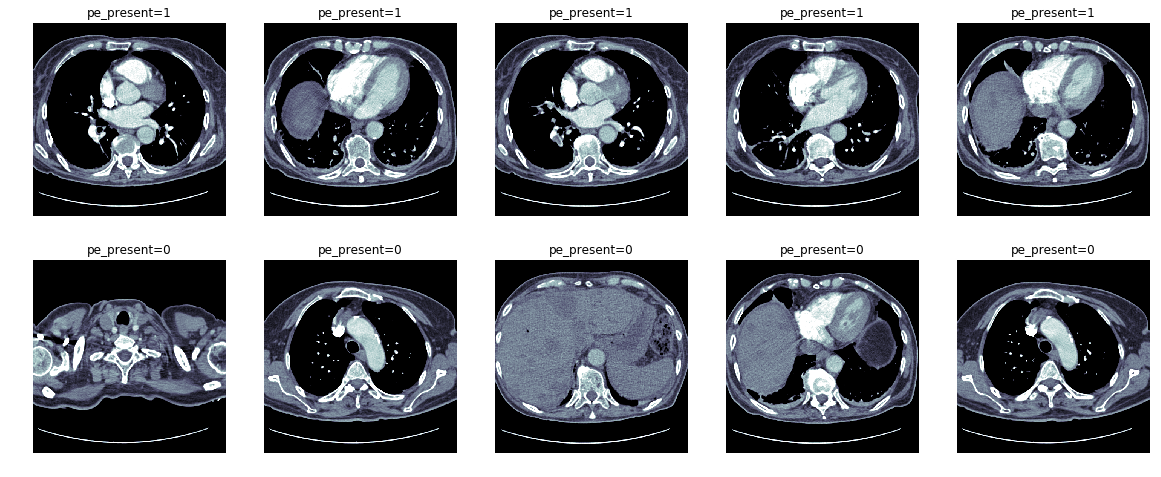

In [8]:
def metadata_window(img, print_ranges=True):
    # Get data from dcm
    window_center, window_width, intercept, slope = get_windowing(img)
    img = img.pixel_array
    
    # Window based on dcm metadata
    img = img * slope + intercept
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    if print_ranges:
        print(f'Window Level: {window_center}, Window Width:{window_width}, Range:[{img_min} {img_max}]')
    img[img < img_min] = img_min
    img[img > img_max] = img_max
    
    # Normalize
    img = (img - img_min) / (img_max - img_min)
    return img
    

print('Metadata Window Ranges:')
view_images([metadata_window(img) for img in imgs])

Looks like the metadata ranges are somewhat similar to the lung-range we initially used. So we will use that in our calculation throughout. 

<a id="4"></a>
<font color="black" size=+2.5><b>4. One Window, Three Channels </b></font>

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to Colors">Go to TOC</a>

Since we'd like to eventually export the scans as png files, we have 3 channels (R,G,B) to work with. If we're only going to use one window setting, we can try to improve the contrast by spreading it out across all 3 channels.

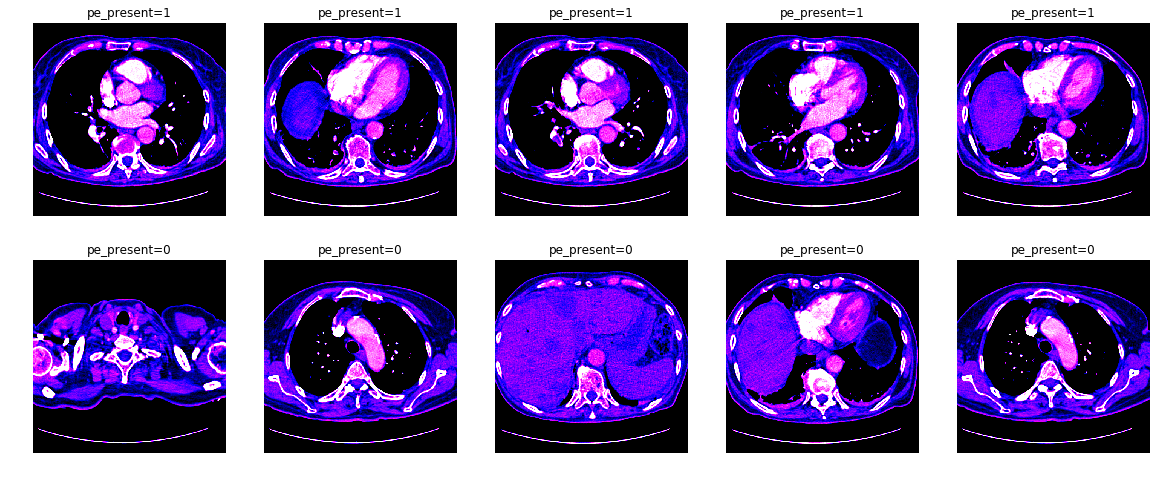

In [9]:
def all_channels_window(img):
    grey_img = lung_window(img) * 3.0
    all_chan_img = np.zeros((grey_img.shape[0], grey_img.shape[1], 3))
    all_chan_img[:, :, 2] = np.clip(grey_img, 0.0, 1.0)
    all_chan_img[:, :, 0] = np.clip(grey_img - 1.0, 0.0, 1.0)
    all_chan_img[:, :, 1] = np.clip(grey_img - 2.0, 0.0, 1.0)
    return all_chan_img
    

view_images([all_channels_window(img) for img in imgs])

<a id="5"></a>
<font color="black" size=+2.5><b>5. Gradient Windowing </b></font>

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to Colors">Go to TOC</a>

We can spread our a single window across channels a different way, by mapping the pixel values to a gradient.

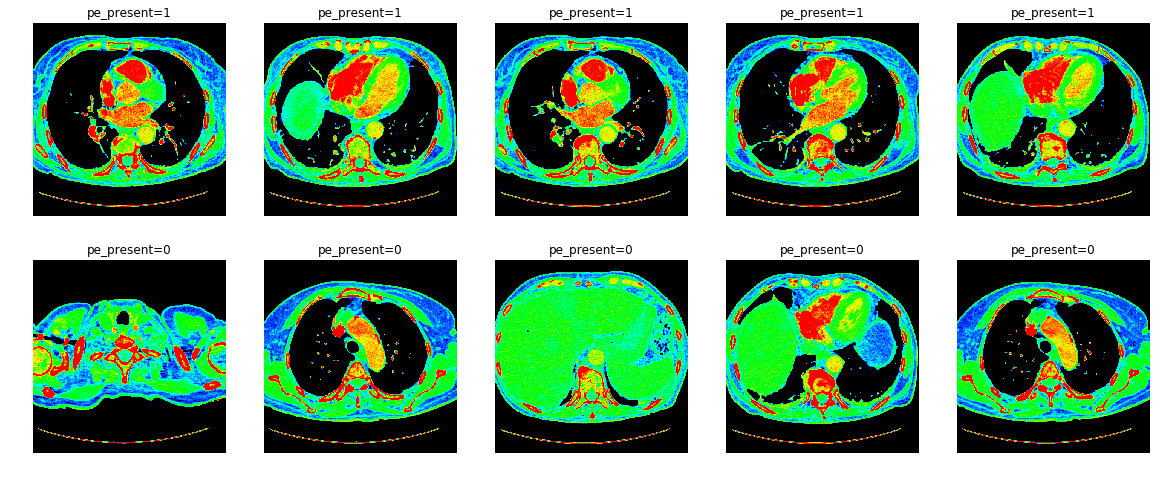

In [10]:
def map_to_gradient(grey_img):
    rainbow_img = np.zeros((grey_img.shape[0], grey_img.shape[1], 3))
    rainbow_img[:, :, 0] = np.clip(4 * grey_img - 2, 0, 1.0) * (grey_img > 0) * (grey_img <= 1.0)
    rainbow_img[:, :, 1] =  np.clip(4 * grey_img * (grey_img <=0.75), 0,1) + np.clip((-4*grey_img + 4) * (grey_img > 0.75), 0, 1)
    rainbow_img[:, :, 2] = np.clip(-4 * grey_img + 2, 0, 1.0) * (grey_img > 0) * (grey_img <= 1.0)
    return rainbow_img

def rainbow_window(img):
    grey_img = lung_window(img)
    return map_to_gradient(grey_img)

view_images([rainbow_window(img) for img in imgs])

<a id="6"></a>
<font color="black" size=+2.5><b>6. Mapping Multiple Windows in Multiple Channels </b></font>

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to Colors">Go to TOC</a>

* As David points out in his Kernel, different density tissue become more obvious at different window settings.. We can include more than one window in our training images by storing a different window in each channel.

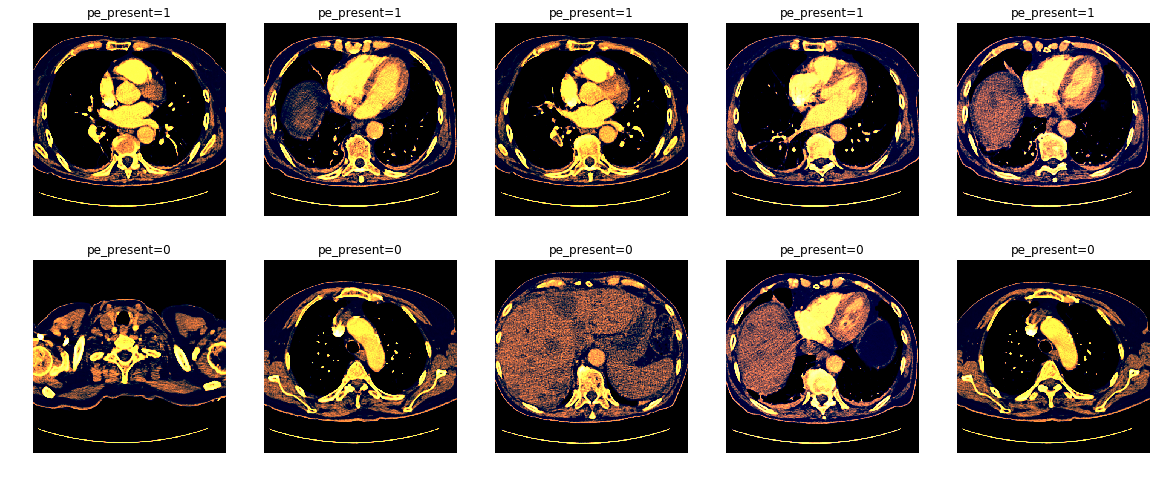

In [11]:
def window_image(img, window_center, window_width):
    _, _, intercept, slope = get_windowing(img)
    img = img.pixel_array * slope + intercept
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    img[img < img_min] = img_min
    img[img > img_max] = img_max
    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    return img


def bsb_window(img):
    lung_img1 = window_image(img, 40, 80)
    lung_img2 = window_image(img, 80, 200)
    lung_img3 = window_image(img, 600, 2000)
    
    bsb_img = np.zeros((lung_img1.shape[0], lung_img1.shape[1], 3))
    bsb_img[:, :, 0] = lung_img1
    bsb_img[:, :, 1] = lung_img2
    bsb_img[:, :, 2] = lung_img3
    return bsb_img

view_images([bsb_window(img) for img in imgs])

<a id="7"></a>
<font color="black" size=+2.5><b>7. Exclusive Windowing </b></font>

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to Colors">Go to TOC</a>

Same idea as above, but removing values outside the window range by setting them to 0.

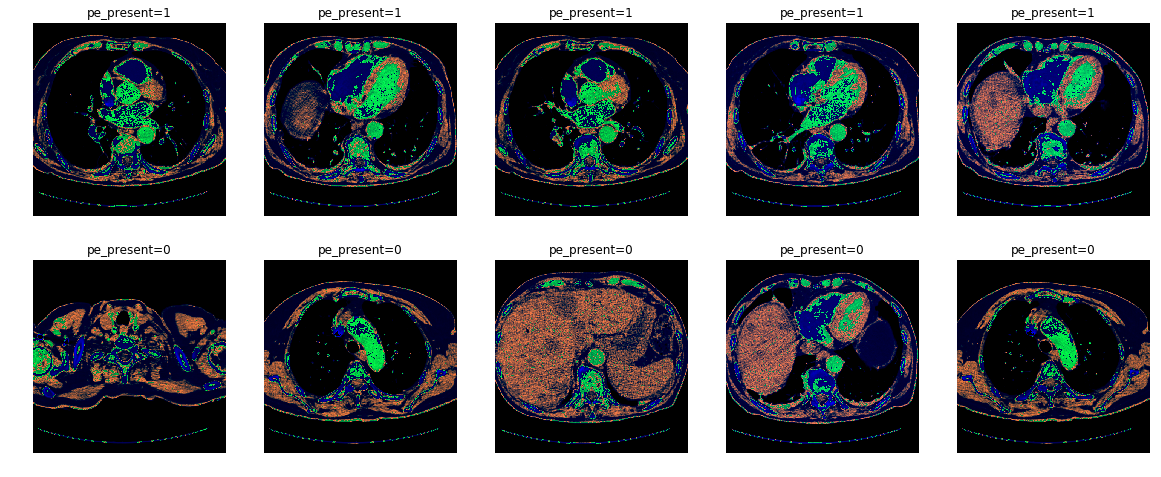

In [12]:
def window_image_bottom(img, window_center, window_width):
    _, _, intercept, slope = get_windowing(img)
    img = img.pixel_array * slope + intercept
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    img[img < img_min] = img_min
    img[img > img_max] = img_min
    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    return img


def bsb_window(img):
    lung_img1 = window_image_bottom(img, 40, 80)
    lung_img2 = window_image_bottom(img, 80, 200)
    lung_img3 = window_image_bottom(img, 600, 2000)
    
    bsb_img = np.zeros((lung_img1.shape[0], lung_img1.shape[1], 3))
    bsb_img[:, :, 0] = lung_img1
    bsb_img[:, :, 1] = lung_img2
    bsb_img[:, :, 2] = lung_img3
    return bsb_img

view_images([bsb_window(img) for img in imgs])

<a id="8"></a>
<font color="black" size=+2.5><b>8. Gradient Ensemble Windowing </b></font>

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to Colors">Go to TOC</a>

We can combine a few previous ideas by averaging 3 different window settings and then mapping the results to a gradient.

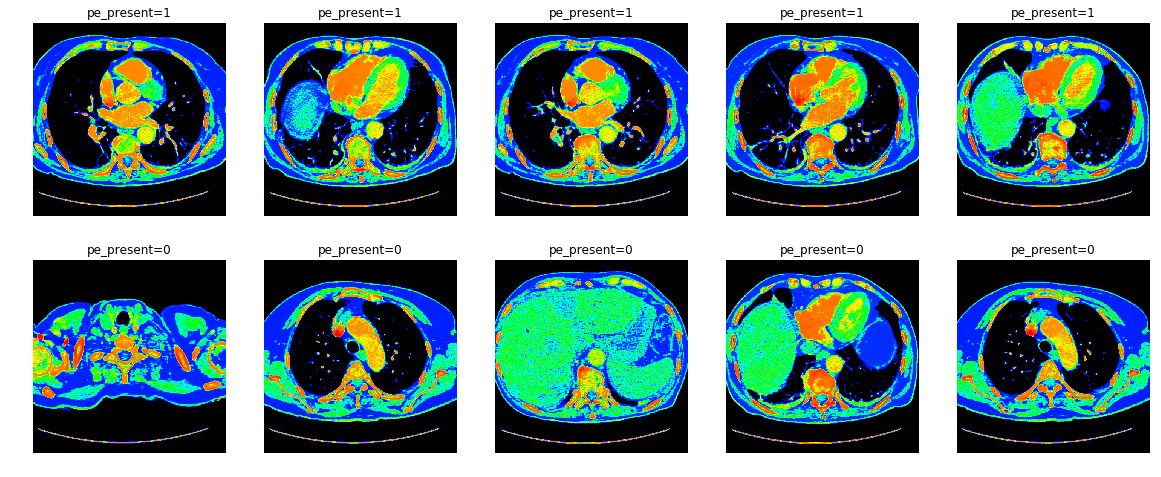

In [13]:
def rainbow_bsb_window(img):
    lung_img1 = window_image(img, 40, 80)
    lung_img2 = window_image(img, 80, 200)
    lung_img3 = window_image(img, 600, 2000)
    combo = (lung_img1*0.3 + lung_img2*0.5 + lung_img3*0.2)
    return map_to_gradient(combo)

view_images([rainbow_bsb_window(img) for img in imgs])

<a id="9"></a>
<font color="black" size=+2.5><b>9. Sigmoid Windowing </b></font>

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to Colors">Go to TOC</a>

Instead of simply clipping values outside of our window, we can use a sigmoid function to increase the variance near the middle of the window, while limiting the variance at the extremes. (I didn't come up with this, I believe it's a pretty common way to window.)

This looks like it does a better job creating contrast near the center of the window and we aren't losing any data like we do when we clip to a min/max.

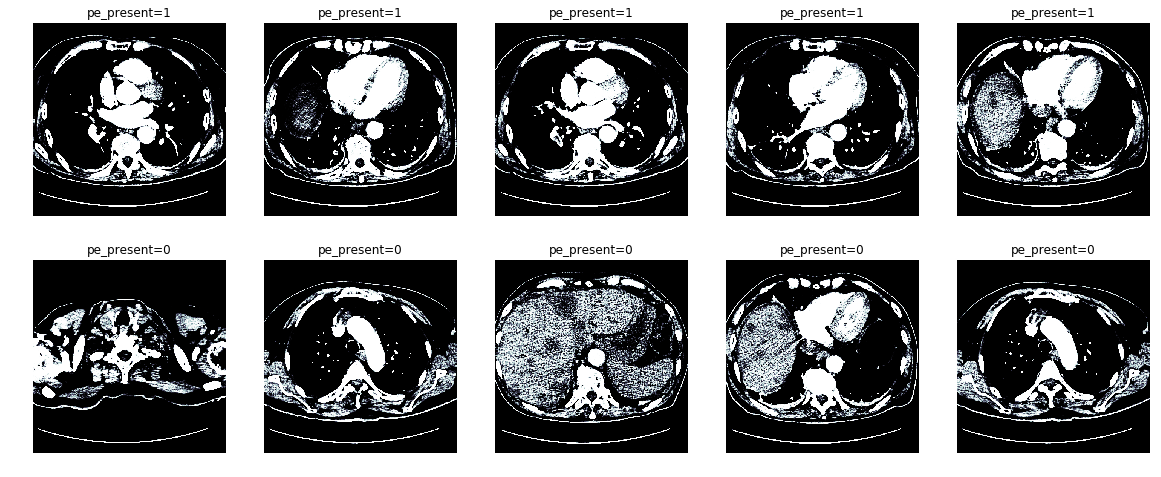

In [14]:
def sigmoid_window(img, window_center, window_width, U=1.0, eps=(1.0 / 255.0)):
    _, _, intercept, slope = get_windowing(img)
    img = img.pixel_array * slope + intercept
    ue = np.log((U / eps) - 1.0)
    W = (2 / window_width) * ue
    b = ((-2 * window_center) / window_width) * ue
    z = W * img + b
    img = U / (1 + np.power(np.e, -1.0 * z))
    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    return img

def sigmoid_brain_window(img):
    return sigmoid_window(img, 40, 80)

view_images([sigmoid_brain_window(img) for img in imgs])

<a id="10"></a>
<font color="black" size=+2.5><b>10. Sigmoid Ensemble Windowing </b></font>

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to Colors">Go to TOC</a>

Again, combining two previous ideas.

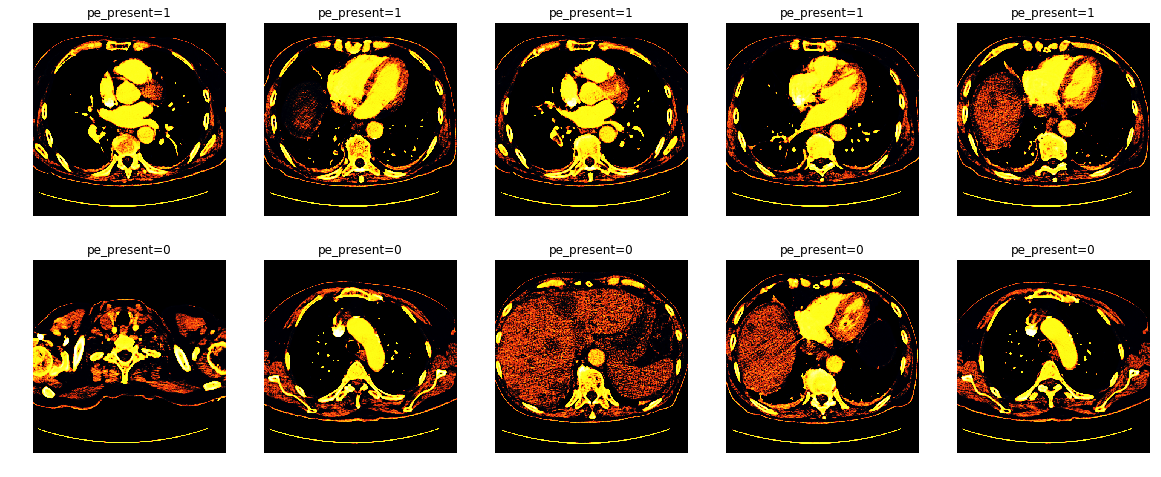

In [15]:
def sigmoid_bsb_window(img):
    lung_img1 = sigmoid_window(img, 40, 80)
    lung_img2 = sigmoid_window(img, 80, 200)
    lung_img3 = sigmoid_window(img, 600, 2000)
    
    bsb_img = np.zeros((lung_img1.shape[0], lung_img1.shape[1], 3))
    bsb_img[:, :, 0] = lung_img1
    bsb_img[:, :, 1] = lung_img2
    bsb_img[:, :, 2] = lung_img3
    return bsb_img

view_images([sigmoid_bsb_window(img) for img in imgs])

<a id="11"></a>
<font color="black" size=+2.5><b>11. Sigmoid Gradient Ensemble Windowing </b></font>

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to Colors">Go to TOC</a>


And finally, putting it all together.

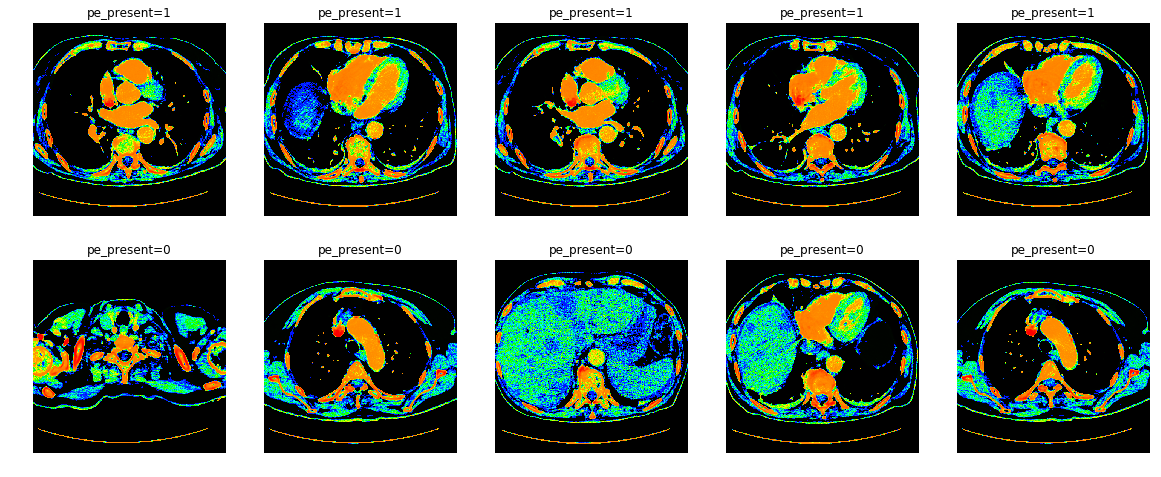

In [16]:
def map_to_gradient_sig(grey_img):
    rainbow_img = np.zeros((grey_img.shape[0], grey_img.shape[1], 3))
    rainbow_img[:, :, 0] = np.clip(4*grey_img - 2, 0, 1.0) * (grey_img > 0.01) * (grey_img <= 1.0)
    rainbow_img[:, :, 1] =  np.clip(4*grey_img * (grey_img <=0.75), 0,1) + np.clip((-4*grey_img + 4) * (grey_img > 0.75), 0, 1)
    rainbow_img[:, :, 2] = np.clip(-4*grey_img + 2, 0, 1.0) * (grey_img > 0.01) * (grey_img <= 1.0)
    return rainbow_img

def sigmoid_rainbow_bsb_window(img):
    lung_img1 = sigmoid_window(img, 40, 80)
    lung_img2 = sigmoid_window(img, 80, 200)
    lung_img3 = sigmoid_window(img, 600, 2000)
    combo = (lung_img1*0.35 + lung_img2*0.5 + lung_img3*0.15)
    combo_norm = (combo - np.min(combo)) / (np.max(combo) - np.min(combo))
    return map_to_gradient_sig(combo_norm)

view_images([sigmoid_rainbow_bsb_window(img) for img in imgs])

<a id="12"></a>
<font color="black" size=+2.5><b>12. Channelwise Windowing </b></font>

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to Colors">Go to TOC</a>

The values in CT scans tend to range from -1000 to 3000; we are used to 8-bit images with pixel values ranging from 0 to 255. Radiologists use a technique called windowing to visualize CT scans. Different types of tissues are better evaluated using different windows. Windows are defined by 2 numbers: window width and window level.


Note that these images are single channel. I have provided them in 3-channel RGB format. Each channel is a different window.

* RED channel / LUNG window / level=-600, width=1500
* GREEN channel / PE window / level=100, width=700
* BLUE channel / MEDIASTINAL window / level=40, width=400



In [17]:
def window(img, WL=50, WW=350):
    upper, lower = WL+WW//2, WL-WW//2
    X = np.clip(img.copy(), lower, upper)
    X = X - np.min(X)
    X = X / np.max(X)
    X = (X*255.0).astype('uint8')
    return X

image_raw = imgs[4].pixel_array

image_lung = np.expand_dims(window(image_raw, WL=-600, WW=1500), axis=3)
image_mediastinal = np.expand_dims(window(image_raw, WL=40, WW=400), axis=3)
image_pe_specific = np.expand_dims(window(image_raw, WL=100, WW=700), axis=3)
# image = np.concatenate([image_mediastinal, image_pe_specific, image_lung], axis=3)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  if sys.path[0] == '':
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  del sys.path[0]


In [18]:
rgb = np.dstack((image_lung,image_mediastinal,image_pe_specific))

Text(0.5, 1.0, 'Merged RGB')

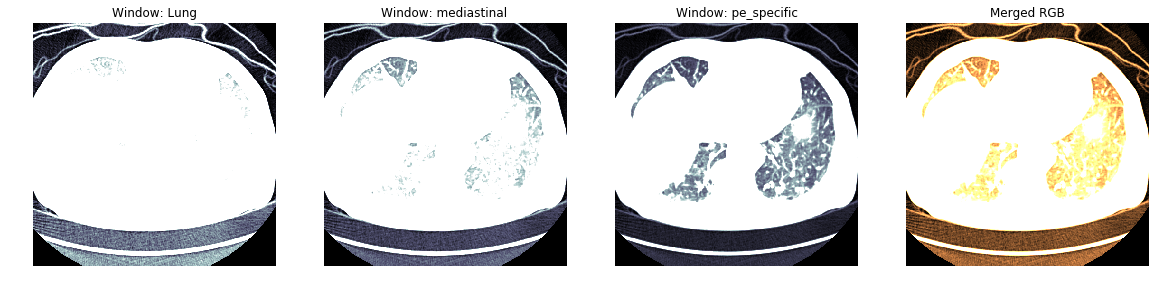

In [19]:
f, ax = plt.subplots(1,4, figsize=(20, 10))
ax[0].imshow(image_lung.squeeze(), cmap='bone')
ax[0].axis('off')
ax[0].set_title('Window: Lung')

ax[1].imshow(image_mediastinal.squeeze(), cmap='bone')
ax[1].axis('off')
ax[1].set_title('Window: mediastinal ')

ax[2].imshow(image_pe_specific.squeeze(), cmap='bone')
ax[2].axis('off')
ax[2].set_title('Window: pe_specific')

ax[3].imshow(rgb )
ax[3].axis('off')
ax[3].set_title('Merged RGB')

I haven't done enough experimenting to know which one of these works best because I haven't submitted any prediction to the competition.  I was thinking these might help add some diversity to an ensemble?

Thanks for reading and let me know if you have any questions or comments! **Also, if you found any of this interesting, don't forget to upvote.** 😄

## Acknowledgements <a></a>
Thanks again to [David Tang](https://www.kaggle.com/dcstang/see-like-a-radiologist-with-systematic-windowing), [Marco](https://www.kaggle.com/marcovasquez/basic-eda-data-visualization), [Nanashi](https://www.kaggle.com/jesucristo/rsna-introduction-eda-models), [Richard McKinley](https://www.kaggle.com/omission/eda-view-dicom-images-with-correct-windowing) and [Ryan Epp](https://www.kaggle.com/reppic/gradient-sigmoid-windowing) for sharing their excellent kernels.

Ideas were also borrowed from [Practical Window Setting Optimization for Medical Image Deep Learning](https://arxiv.org/pdf/1812.00572.pdf) and [Precise diagnosis of intracranial hemorrhage and subtypes using a three-dimensional joint convolutional and recurrent neural network](https://rd.springer.com/content/pdf/10.1007%2Fs00330-019-06163-2.pdf)

**Update 10/22: ** The `sigmoid_window` function can be pretty slow when processing the whole dataset on a cpu. You can get a nice speedup by running it on your gpu using cupy :)

In [20]:
# import cupy as cp

# def sigmoid_window(dcm, img, window_center, window_width, U=1.0, eps=(1.0 / 255.0)):
#     img = cp.array(np.array(img))
#     _, _, intercept, slope = get_windowing(dcm)
#     img = img * slope + intercept
#     ue = cp.log((U / eps) - 1.0)
#     W = (2 / window_width) * ue
#     b = ((-2 * window_center) / window_width) * ue
#     z = W * img + b
#     img = U / (1 + cp.power(np.e, -1.0 * z))
#     img = (img - cp.min(img)) / (cp.max(img) - cp.min(img))
#     return cp.asnumpy(img)

![](https://www.clipartmax.com/png/middle/265-2655834_work-in-progress-icon.png)





### In the meantime, check out my other ongoing works in this same competition: 
💥 [RSNA-STR Pulmonary Embolism [Dummy Sub]](https://www.kaggle.com/redwankarimsony/rsna-str-pulmonary-embolism-dummy-sub)<br>
💥 [CT-Scans, DICOM files, Windowing Explained](https://www.kaggle.com/redwankarimsony/ct-scans-dicom-files-windowing-explained)<br>
💥 [RSNA-STR-PE [Gradient & Sigmoid Windowing]](https://www.kaggle.com/redwankarimsony/rsna-str-pe-gradient-sigmoid-windowing)<br>
💥 [RSNA-STR [✔️3D Stacking ✔️3D Plot ✔️Segmentation]](https://www.kaggle.com/redwankarimsony/rsna-str-3d-stacking-3d-plot-segmentation/edit/run/42517982)<br>
💥 [RSNA-STR [DICOM 👉 GIF 👉 npy]](https://www.kaggle.com/redwankarimsony/rsna-str-dicom-gif-npy)<br>
💥 [RSNA-STR Pulmonary Embolism [EDA]](https://www.kaggle.com/redwankarimsony/rsna-str-pulmonary-embolism-eda)<br>